In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [2]:
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, 
                                                            test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, 
                                                  test_size=0.2, random_state=42)
print(x_train.shape, x_val.shape)

(364, 30) (91, 30)


In [10]:
class SingleLayer:
    def __init__(self, learning_rate=0.1, l1=0, l2=0):
        self.w = None              # 가중치
        self.b = None              # 절편
        self.losses = []           # 훈련 손실
        self.val_losses = []       # 검증 손실
        self.w_history = []        # 가중치 기록
        self.lr = learning_rate    # 학습률
        self.l1 = l1               # L1 손실 하이퍼파라미터
        self.l2 = l2               # L2 손실 하이퍼파라미터
        
    def forpass(self, x):
        z = np.dot(x, self.w) + self.b
        return z
    
    def backprop(self, x, err):
        m = len(x)
        w_grad = np.dot(x.T, err) / m  #가중치에 대한 그래디언트 계산
        b_grad = np.sum(err) / m       #절편에 대한 그래디언트 계산
        return w_grad, b_grad
    
    def activation(self, z):
        z = np.clip(z, -100, None)     #안전한 계산을 위해
        a = 1 / (1 + np.exp(-z))       #시그모이드 계산
        return a
    
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y = y.reshape(-1, 1)           #타깃을 열 벡터로 바꿈
        m = len(x)
        self.w = np.ones((x.shape[1], 1)) #가중치 초기화
        self.b = 0                        #절편 초기화
        self.w_history.append(self.w.copy())  #가중치를 기록
        
        #epochs만큼 반복
        for i in range(epochs):
            z = self.forpass(x)    #정방향 계산
            a = self.activation(z) #활성화함수 적용
            err = -(y - a)         #오차
            w_grad, b_grad = self.backprop(x, err) #오차를 역전파하여 그래디언트 계산
            w_grad += (self.l1 * np.sign(self.w) + self.l2 * self.w) / m
            #가중치와 절편 업데이트
            self.w -= self.lr * w_grad
            self.b -= self.lr * b_grad
            #가중치 기록
            self.w_history.append(self.w.copy())
            a = np.clip(a, 1e-10, 1-1e-10) #안전한 로그계산을 위해 클리핑
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss()) /m)
            self.update_val_loss(x_val, y_val) #검증 세트에 대한 손실 계산
            
    def predict(self, x):
        z = self.forpass(x)
        return z > 0  #스텝 함수 적용
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y.reshape(-1, 1))
    
    def reg_loss(self):  #가중치에 규제 적용
        return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)
    
    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)
        a = self.activation(z)
        a = np.clip(a, 1e-10, 1-1e-10)
        val_loss = np.sum(-(y_val*np.log(a) + (1-y_val)*np.log(1-a)))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

- forpass 함수 
모든 샘플을 사용하여 그래디언트를 계산하는 배치 경사 하강법을 사용했다. 모든 샘플을 적용시켜야 하기 때문에 벡터화하여 np.dot함수(행렬 곱셈 메서드)를 이용해 X와 W를 계산하였다. X는 m개의 샘플과 n개의 특성을 가졌고, 가중치의 개수는 X의 특성의 개수를 따른다. 즉, 행렬 W는 n개의 행을 갖는다.
- backprop 함수
err가 m x 1 행렬이고 X가 m x n 행렬이기 때문에 행렬 곱셈에 적용하기 위해 X를 전치하여 계산하다. ※m은 샘플의 개수, n은 특성의 개수
- fit()
확률적 경사 하강법을 적용한 fit() 메서드에서는 인덱스를 무작위로 섞는 np.random.permutation()함수를 사용하여 이중 for문을 사용하였다. 배치 경사 하강법을 적용한 fit() 메서드에서는 모든 샘플을 사용하기 때문에 인덱스를 섞는 과정을 생략한다.

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)

single_layer = SingleLayer(l2=0.01)
single_layer.fit(x_train_scaled, y_train,x_val=x_val_scaled, y_val=y_val, epochs=10000)
single_layer.score(x_val_scaled, y_val)

0.978021978021978

사이킷런에서 제공하는 StandardScaler를 사용해 원본 데이터의 스케일을 조정해 표준화(Standardization)한다.

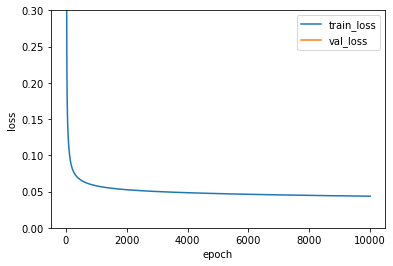

In [15]:
plt.ylim(0, 0.3)
plt.plot(single_layer.losses)
plt.plot(single_layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

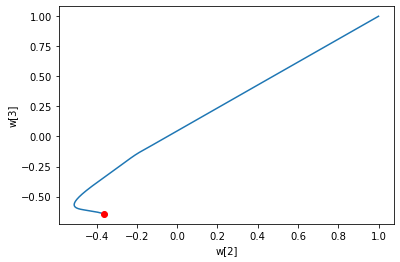

In [13]:
w2 = []
w3 = []
for w in single_layer.w_history:
    w2.append(w[2])
    w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

최적의 가중치를 찾아가는 그래프가 5-1장의 그래프보다 더 매끄럽다.

In [18]:
class DualLayer(SingleLayer):
    
    def __init__(self, units=10, learning_rate=0.1, l1=0, l2=0):
        self.units = units         # 은닉층의 뉴런 개수
        self.w1 = None             # 은닉층의 가중치
        self.b1 = None             # 은닉층의 절편
        self.w2 = None             # 출력층의 가중치
        self.b2 = None             # 출력층의 절편
        self.a1 = None             # 은닉층의 활성화 출력
        self.losses = []           # 훈련 손실
        self.val_losses = []       # 검증 손실
        self.lr = learning_rate    # 학습률
        self.l1 = l1               # L1 손실 하이퍼파라미터
        self.l2 = l2               # L2 손실 하이퍼파라미터
        
    def forpass(self, x):
        z1 = np.dot(x, self.w1) + self.b1 #첫번째 층의 선형 식을 계산
        self.a1 = self.activation(z1)     #활성화 함수 적용
        z2 = np.dot(self.a1, self.w2) + self.b2 #두 번째층의 선형 식을 계산
        return z2
    
    def backprop(self, x, err):
        m = len(x)
        # 출력층의 가중치와 절편에 대한 그래디언트 계산
        w2_grad = np.dot(self.a1.T, err) / m
        b2_grad = np.sum(err) / m
        # 시그모이드 함수까지 그래디언트를 계산
        err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1-self.a1)
        # 은닉층의 가중치와 절편에 대한 그래디언트 계산
        w1_grad = np.dot(x.T, err_to_hidden) / m
        b1_grad = np.sum(err_to_hidden, axis=0) / m
        return w1_grad, b1_grad, w2_grad, b2_grad
    
    def init_weights(self, n_features):
        self.w1 = np.ones((n_features, self.units)) # (특성의 개수, 은닉층의 크기)
        self.b1 = np.zeros(self.units)  # 은닉층의 크기
        self.w2 = np.ones((self.units, 1)) # (은닉층의 크기, 1)
        self.b2 = 0
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y = y.reshape(-1, 1)  # 타깃을 열 벡터로 바꿈
        y_val = y_val.reshape(-1, 1)
        m = len(x) 
        self.init_weights(x.shape[1]) # 은닉층과 출력층의 가중치를 초기화
        for i in range(epochs):
            a = self.training(x, y, m)
            a = np.clip(a, 1e-10, 1-1e-10)
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss()) / m)
            self.update_val_loss(x_val, y_val)
            
    def training(self, x, y, m):
        z = self.forpass(x)
        a = self.activation(z)
        err = -(y - a)
        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        # 그래디언트에 패널티 항의 미분 값을 더함
        w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
        w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
        #은닉층의 가중치와 절편을 업데이트
        self.w1 -= self.lr * w1_grad
        self.b1 -= self.lr * b1_grad
        #출력층의 가중치와 절편을 업데이트
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad
        return a
    
    def reg_loss(self):
        # 은닉층과 출력층의 가중치에 규제를 적용
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

<img src="./MultiLayer.jpg" width="100%" height="100%" />
- backprop
각 단계별 손실 함수를 미분한다.
z2에 대한 미분 값 = -(y - a1)
w2에 대한 미분 값 = a1
b2에 대한 미분 값 = 1
a1에 대한 미분 값 = w2
z1에 대한 미분 값 = a1◉(1-a1)
w1에 대한 미분 값 = x
b1에 대한 미분 값 = 1
<img src="./Backprop.jpg" width="100%" height="100%" />
<w2_grad>는 z2에 대한 미분 값과 w2에 대해 미분 값을 점곱하여 그래디언트를 계산했다. 여기서 a1과 err를 행렬 곱셈하기 위해 a1을 전치하였다. b2_grad는 z2에 대해 미분 값과 b2에 대해 미분한 값을 곱하여 그래디언트를 계산하였다. err_to_hidden는 은닉층의 손실함수를 미분하여 계산한 값으로 z2에 대해 미분한 값과 a1에 대한 미분 값, z1에 대한 미분 값을 곱하여 계산하였다. w1_grad는 z2, a1, z1, w1에 대한 미분 값을 곱한다. b1_grad는 z2, a1, z1, b1에 대한 미분 값을 곱한다. 


In [19]:
dual_layer = DualLayer(l2=0.01)
dual_layer.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=20000)
dual_layer.score(x_val_scaled, y_val)

0.978021978021978

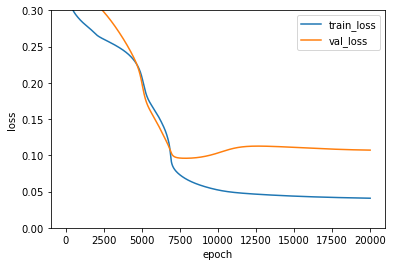

In [20]:
plt.ylim(0, 0.3)
plt.plot(dual_layer.losses)
plt.plot(dual_layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [22]:
class RandomInitNetwork(DualLayer):
    
    def init_weights(self, n_features):
        np.random.seed(42)
        self.w1 = np.random.normal(0, 1, (n_features, self.units)) #(특성 개수, 은닉층의 크기)
        self.b1 = np.zeros(self.units)
        self.w2 = np.random.normal(0, 1, (self.units, 1)) #(은닉층의 크기, 1)
        self.b2 = 0

In [23]:
random_init_net = RandomInitNetwork(l2=0.01)
random_init_net.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=500)

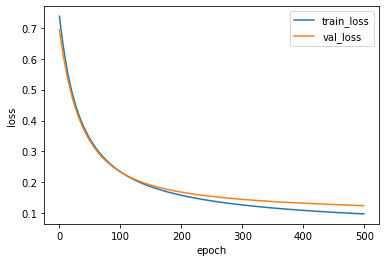

In [24]:
plt.plot(random_init_net.losses)
plt.plot(random_init_net.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

가중치 초기값을 0 또는 1로 초기화한 것보다 랜덤 값으로 초기화 했을 때 손실 함수 그래프가 더 매끄럽다. 즉, 최적의 가중치에 도달하기까지 과정이 랜덤으로 초기화 했을 때가 더 좋다. 

In [28]:
class MinibatchNetwork(RandomInitNetwork):
    
    def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
        super().__init__(units, learning_rate, l1, l2)
        self.batch_size = batch_size
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y_val = y_val.reshape(-1, 1)     # 타깃을 열 벡터로 바꿈
        self.init_weights(x.shape[1])    # 은닉층과 출력층의 가중치 초기화
        np.random.seed(42)
        for i in range(epochs):
            loss = 0
            for x_batch, y_batch in self.gen_batch(x, y):
                y_batch = y_batch.reshape(-1, 1)
                m = len(x_batch)
                a = self.training(x_batch, y_batch, m)
                a = np.clip(a, 1e-10, 1-1e-10)
                loss += np.sum(-(y_batch*np.log(a) + (1-y_batch)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss()) / len(x))
            self.update_val_loss(x_val, y_val)
            
    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size  #미니배치 횟수
        if length % self.batch_size:
            bins += 1   # 나머지가 있다면
        indexes = np.random.permutation(np.arange(len(x))) #인덱스를 섞는다.
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]  #batch_size만큼 슬라이싱 반환

`미니 배치 경사하강법`은 배치 경사하강법과 확률적 경사하강법의 절충안으로 확률적 경사하강법의 무작위성 배치 경사하강법의 여러개 샘플을 적용하는 것과 같은 장점을 합쳐 만든 방법이다.
미니 배치 경사하강법은 전체 훈련 데이터 세트에서 n개의 샘플을 무작위로 선택하여 그래디언트를 계산한다. 샘플 선택과 그래디언트를 반복한다.

In [30]:
minibatch_net = MinibatchNetwork(l2=0.01, batch_size=32)
minibatch_net.fit(x_train_scaled, y_train, 
                  x_val=x_val_scaled, y_val=y_val, epochs=500)
minibatch_net.score(x_val_scaled, y_val)

0.978021978021978

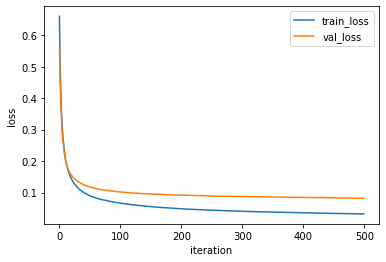

In [31]:
plt.plot(minibatch_net.losses)
plt.plot(minibatch_net.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [32]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(10, ), activation='logistic',
                    solver='sgd', alpha=0.01, batch_size=32,
                    learning_rate_init=0.1, max_iter=1000)
mlp.fit(x_train_scaled, y_train)
mlp.score(x_val_scaled, y_val)

0.989010989010989